In [16]:
from datetime import datetime, timedelta
import pandas as pd
import requests
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.ticker import PercentFormatter
import seaborn as sns
import numpy as np

In [17]:
AMBERDATA_API_KEY = "INSERT_YOUR_API_KEY"
AD_COLORS = ['#1c3664', '#89bed8', '#f16623']

In [18]:
start_date = datetime.strptime("2018-01-01", "%Y-%m-%d")
end_date = datetime.strptime("2023-09-30", "%Y-%m-%d")

btc_usdt = pd.DataFrame()

date_ranges = []
while start_date < end_date:
    new_end_date = start_date + timedelta(days=30)
    date_ranges.append((start_date, new_end_date))
    start_date = new_end_date

for start, end in date_ranges:
    url = f"https://web3api.io/api/v2/market/spot/ohlcv/exchange/binance/historical?pair=btc_usdt&timeInterval=hours&startDate={start.strftime('%Y-%m-%dT%H:%M:%S')}&endDate={end.strftime('%Y-%m-%dT%H:%M:%S')}"
    
    headers = {
        "accept": "application/json",
        "x-api-key": AMBERDATA_API_KEY
    }
    
    response = requests.get(url, headers=headers)
    data = response.json()
    usdc_usdt_data = data['payload']['data']['btc_usdt']
    columns = data['payload']['metadata']['columns']
    df = pd.DataFrame(usdc_usdt_data, columns=columns)
    df['timestamp'] = pd.to_datetime(df['timestamp'], unit='ms')
    df.set_index('timestamp', inplace=True)
    btc_usdt = pd.concat([btc_usdt, df])

btc_usdt['returns'] = np.log(btc_usdt['close'] / btc_usdt['close'].shift(1))

In [19]:
market_hours = {
    'US': range(13, 20),  # 9:30am - 4:00pm Eastern Time
    'EU': {
        'LSE (EU)': range(7, 15),  # 8:00am - 4:30pm London Time
        'FSE (EU)': range(8, 16)   # 9:00am - 5:30pm Central European Time
    },
    'Asia': range(1, 8),  # 9:30am - 4:00pm Hong Kong Time
    'Japan': range(0, 6),  # 9:00am - 3:00pm Tokyo Time
    'India': range(3, 10),  # 9:15am - 3:30pm Mumbai Time
}

volatility_data = {}

for region, hours in market_hours.items():
    if isinstance(hours, dict):
        for sub_region, sub_hours in hours.items():
            in_market = btc_usdt.index.hour.isin(sub_hours)
            volatility_during = btc_usdt[in_market]['returns'].std()
            volatility_outside = btc_usdt[~in_market]['returns'].std()
            volatility_data[sub_region] = {
                'During Market Hours': volatility_during,
                'Outside Market Hours': volatility_outside
            }
    else:
        in_market = btc_usdt.index.hour.isin(hours)
        volatility_during = btc_usdt[in_market]['returns'].std()
        volatility_outside = btc_usdt[~in_market]['returns'].std()
        volatility_data[region] = {
            'During Market Hours': volatility_during,
            'Outside Market Hours': volatility_outside
        }

volatility_df = pd.DataFrame(volatility_data).T

<Figure size 1600x1200 with 0 Axes>

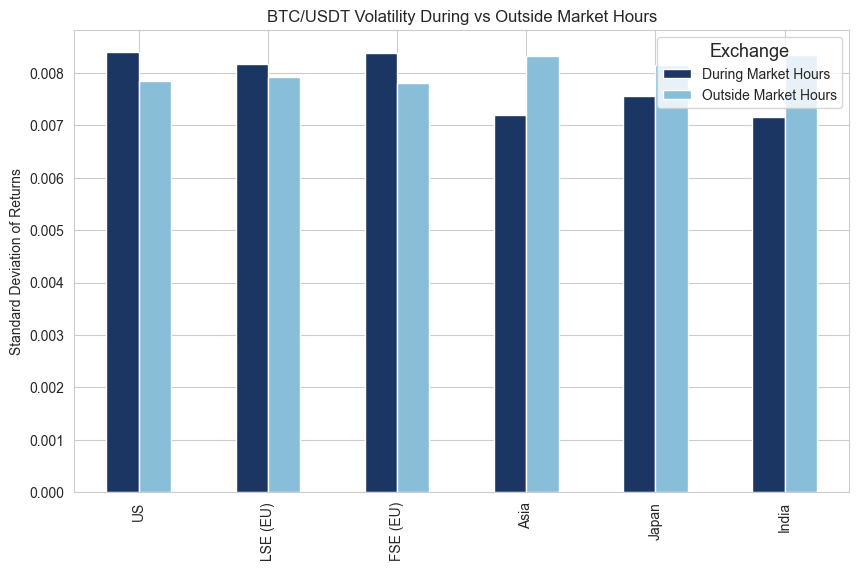

In [20]:
plt.figure(dpi=250)
ax = volatility_df.plot(kind='bar', figsize=(10, 6), color=AD_COLORS)
plt.title('BTC/USDT Volatility During vs Outside Market Hours')
plt.ylabel('Standard Deviation of Returns')
plt.legend(title='Exchange', title_fontsize='13', fontsize='10')
plt.show()

In [21]:
print(volatility_df)

          During Market Hours  Outside Market Hours
US                   0.008401              0.007845
LSE (EU)             0.008181              0.007925
FSE (EU)             0.008383              0.007818
Asia                 0.007203              0.008319
Japan                0.007566              0.008153
India                0.007158              0.008335


<Figure size 1600x1200 with 0 Axes>

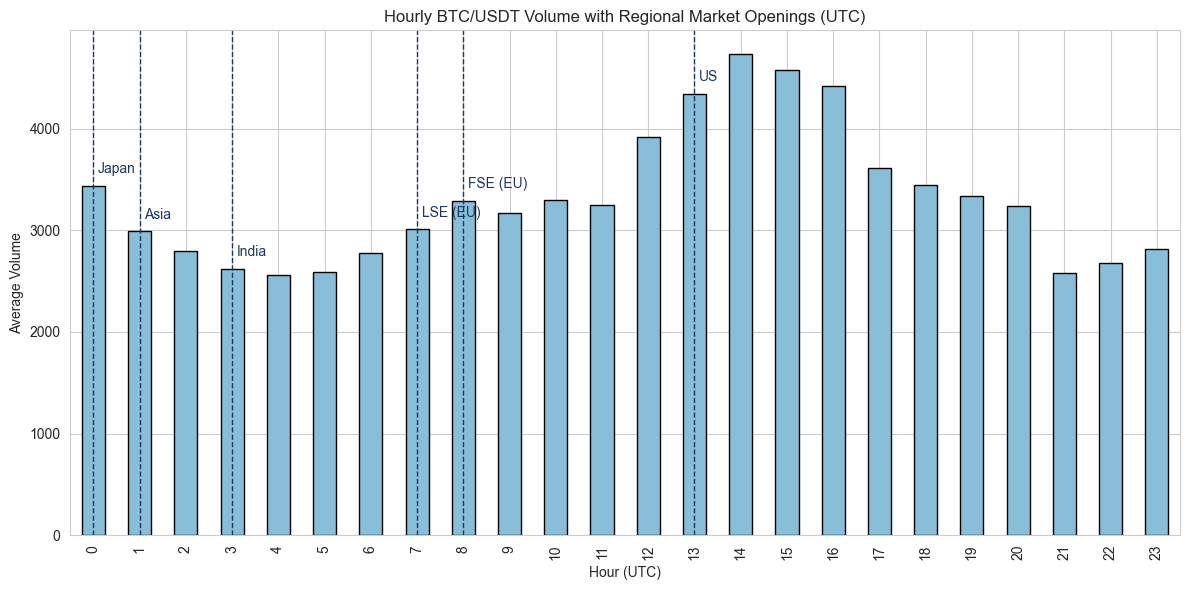

In [22]:
plt.figure(dpi=250)

avg_volume = btc_usdt.groupby(btc_usdt.index.hour)['volume'].mean()

fig, ax = plt.subplots(figsize=(12, 6))

avg_volume.plot(kind='bar', ax=ax, color=AD_COLORS[1], edgecolor='black', title="Hourly BTC/USDT Volume with Regional Market Openings (UTC)")

for region, hours in market_hours.items():
    if isinstance(hours, dict):
        for sub_region, sub_hours in hours.items():
            start_hour = sub_hours[0]
            end_hour = sub_hours[-1]

            ax.axvline(x=start_hour, color=AD_COLORS[0], linestyle='--', lw=1)

            y_val = avg_volume[start_hour] + 0.02 * avg_volume.max()
            ax.text(start_hour + 0.1, y_val, sub_region, color=AD_COLORS[0], rotation=0, verticalalignment='bottom')
    else:
        start_hour = hours[0]
        end_hour = hours[-1]

        ax.axvline(x=start_hour, color=AD_COLORS[0], linestyle='--', lw=1)

        y_val = avg_volume[start_hour] + 0.02 * avg_volume.max()
        ax.text(start_hour + 0.1, y_val, region, color=AD_COLORS[0], rotation=0, verticalalignment='bottom')

ax.set_xlabel("Hour (UTC)")
ax.set_ylabel("Average Volume")
plt.xticks(range(24), range(24))
plt.tight_layout()
plt.show()

In [23]:
print("Average hourly BTC-USDT Volume:")
print(avg_volume)

print("\nMarket Open Hours:")
for region, hours in market_hours.items():
    if isinstance(hours, dict):
        for sub_region, sub_hours in hours.items():
            print(f"{sub_region} (part of {region}): {sub_hours[0]}:00 - {sub_hours[1]}:00 UTC")
    else:
        print(f"{region}: {hours[0]}:00 - {hours[1]}:00 UTC")

Average hourly BTC-USDT Volume:
timestamp
0     3438.462688
1     2991.853806
2     2798.145688
3     2622.974126
4     2562.758409
5     2587.540566
6     2779.339914
7     3009.174300
8     3288.775273
9     3172.861260
10    3302.823445
11    3245.584380
12    3919.785840
13    4341.088455
14    4730.203904
15    4573.643037
16    4424.190383
17    3617.216800
18    3448.663098
19    3338.518185
20    3237.118388
21    2575.821689
22    2682.492840
23    2811.511336
Name: volume, dtype: float64

Market Open Hours:
US: 13:00 - 14:00 UTC
LSE (EU) (part of EU): 7:00 - 8:00 UTC
FSE (EU) (part of EU): 8:00 - 9:00 UTC
Asia: 1:00 - 2:00 UTC
Japan: 0:00 - 1:00 UTC
India: 3:00 - 4:00 UTC


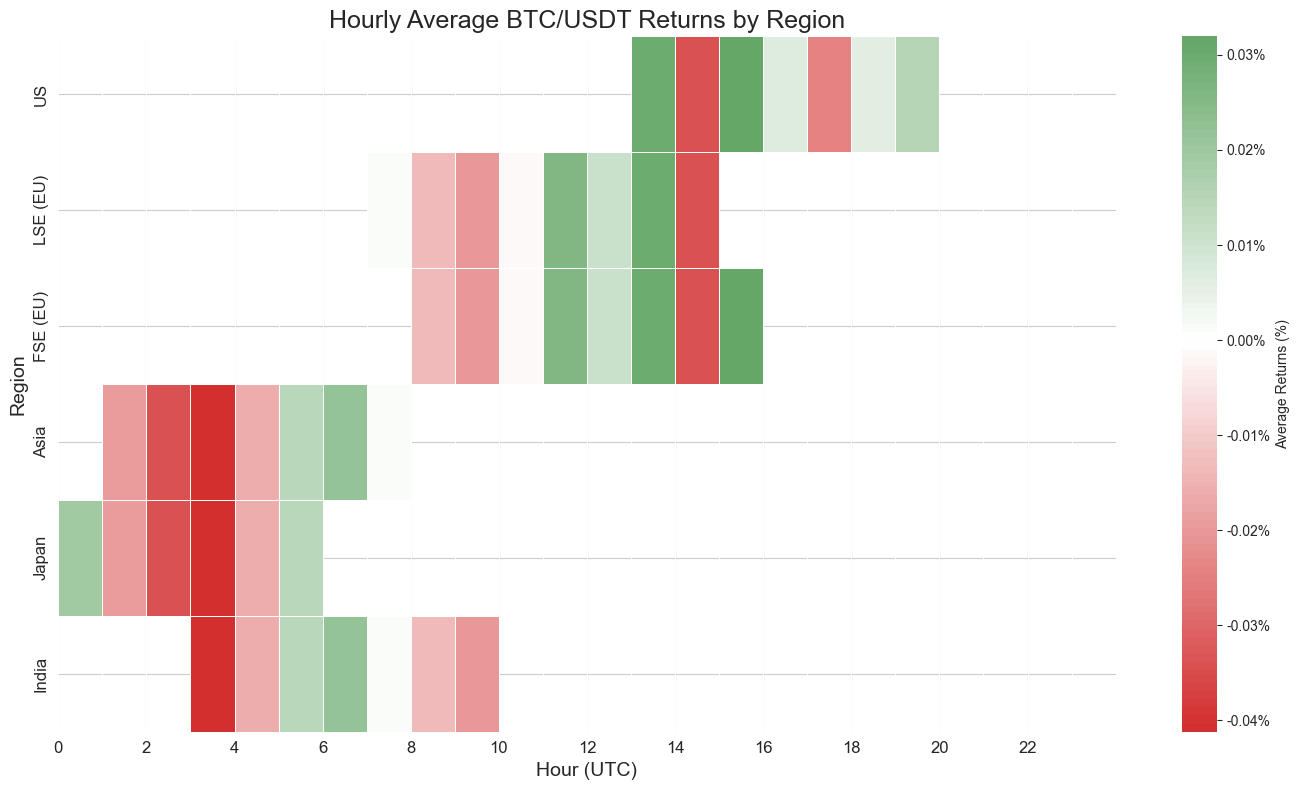

In [24]:
avg_returns_per_hour = pd.DataFrame(index=range(24))

for region, hours in market_hours.items():
    if isinstance(hours, dict):
        for sub_region, sub_hours in hours.items():
            avg_returns = []
            for hour in range(24):
                if hour in sub_hours:
                    hourly_returns = btc_usdt[btc_usdt.index.hour == hour]['returns']
                    avg_returns.append(hourly_returns.mean() * 100)
                else:
                    avg_returns.append(np.nan)
            avg_returns_per_hour[sub_region] = avg_returns
    else:
        avg_returns = []
        for hour in range(24):
            if hour in hours:
                hourly_returns = btc_usdt[btc_usdt.index.hour == hour]['returns']
                avg_returns.append(hourly_returns.mean() * 100)
            else:
                avg_returns.append(np.nan)
        avg_returns_per_hour[region] = avg_returns

colors = ["#d32f2f", "#ffffff", "#388e3c"]
n_bins = 100
cmap_name = "custom_colormap"
custom_colormap = LinearSegmentedColormap.from_list(cmap_name, colors, N=n_bins)

sns.set_style("whitegrid")

plt.figure(figsize=(14, 8))
ax = sns.heatmap(
    avg_returns_per_hour.T,
    annot=False,
    cmap=custom_colormap,
    center=0,
    linewidths=0.5,
    cbar_kws={'format': '%.2f%%', 'label': 'Average Returns (%)'}
)

ax.set_title('Hourly Average BTC/USDT Returns by Region', fontsize=18)
ax.set_xlabel('Hour (UTC)', fontsize=14)
ax.set_ylabel('Region', fontsize=14)

ax.set_xticks(range(0, 24, 2))
ax.set_xticklabels(range(0, 24, 2), fontsize=12)
ax.set_yticklabels(ax.get_yticklabels(), fontsize=12)

plt.tight_layout()
plt.show()

In [25]:
print("Average hourly BTC-USDT Returns (%):")
print(avg_returns_per_hour)

Average hourly BTC-USDT Returns (%):
          US  LSE (EU)  FSE (EU)      Asia     Japan     India
0        NaN       NaN       NaN       NaN  0.019148       NaN
1        NaN       NaN       NaN -0.018982 -0.018982       NaN
2        NaN       NaN       NaN -0.033815 -0.033815       NaN
3        NaN       NaN       NaN -0.041183 -0.041183 -0.041183
4        NaN       NaN       NaN -0.016282 -0.016282 -0.016282
5        NaN       NaN       NaN  0.014171  0.014171  0.014171
6        NaN       NaN       NaN  0.021456       NaN  0.021456
7        NaN  0.001308       NaN  0.001308       NaN  0.001308
8        NaN -0.013646 -0.013646       NaN       NaN -0.013646
9        NaN -0.019909 -0.019909       NaN       NaN -0.019909
10       NaN -0.001669 -0.001669       NaN       NaN       NaN
11       NaN  0.025774  0.025774       NaN       NaN       NaN
12       NaN  0.011184  0.011184       NaN       NaN       NaN
13  0.029522  0.029522  0.029522       NaN       NaN       NaN
14 -0.034268 -0.03

In [26]:
total_returns_per_region = avg_returns_per_hour.sum()

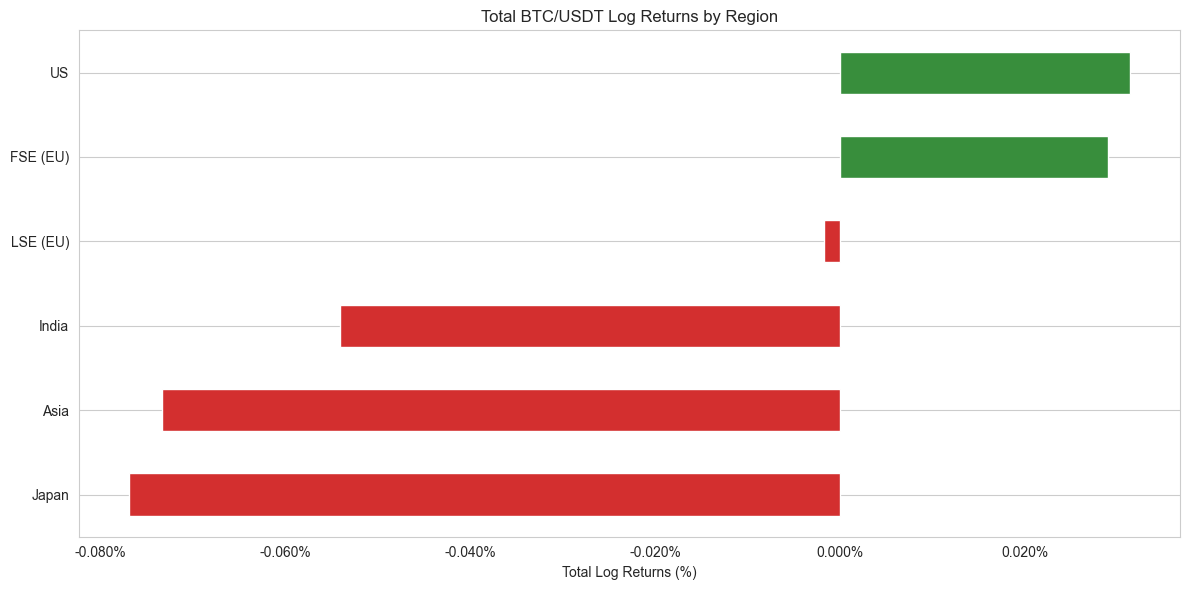

In [27]:
sorted_total_returns = total_returns_per_region.sort_values()
colors = ['#388e3c' if x > 0 else '#d32f2f' for x in sorted_total_returns]

plt.figure(figsize=(12, 6))
ax = sorted_total_returns.plot(kind='barh', color=colors)
plt.xlabel('Total Log Returns (%)')
plt.title('Total BTC/USDT Log Returns by Region')
plt.grid(axis='x')

ax.xaxis.set_major_formatter(plt.FuncFormatter('{:.3f}%'.format))

plt.tight_layout()
plt.show()

In [28]:
print("Total Log Returns by Region (%):")
print(sorted_total_returns)

Total Log Returns by Region (%):
Japan      -0.076944
Asia       -0.073327
India      -0.054084
LSE (EU)   -0.001702
FSE (EU)    0.028940
US          0.031355
dtype: float64


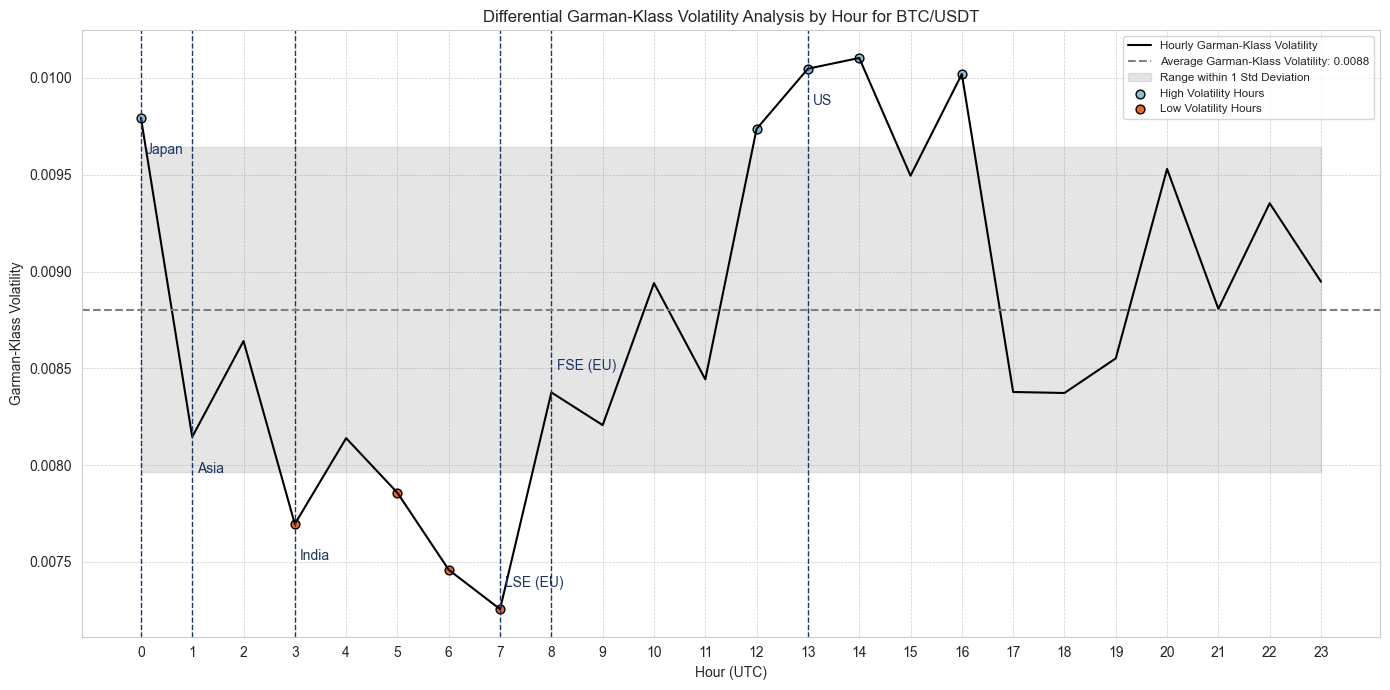

In [29]:
def garman_klass_volatility(row):
    return 0.5 * np.log(row['high'] / row['low'])**2 - (2*np.log(2)-1) * np.log(row['close'] / row['open'])**2

btc_usdt['garman_klass'] = btc_usdt.apply(garman_klass_volatility, axis=1)

avg_gk_volatility = np.sqrt(btc_usdt['garman_klass'].mean())
std_gk_volatility = np.sqrt(btc_usdt.groupby(btc_usdt.index.hour)['garman_klass'].mean()).std()

hourly_gk_volatility = np.sqrt(btc_usdt.groupby(btc_usdt.index.hour)['garman_klass'].mean())

high_gk_volatility_hours = hourly_gk_volatility[hourly_gk_volatility > avg_gk_volatility + std_gk_volatility]
low_gk_volatility_hours = hourly_gk_volatility[hourly_gk_volatility < avg_gk_volatility - std_gk_volatility]

plt.figure(figsize=(14, 7))
hourly_gk_volatility.plot(kind='line', label='Hourly Garman-Klass Volatility', color='black')

for region, hours in market_hours.items():
    if isinstance(hours, dict):
        for sub_region, sub_hours in hours.items():
            start_hour = sub_hours[0]
            plt.axvline(x=start_hour, color=AD_COLORS[0], linestyle='--', lw=1)
            
            y_val = hourly_gk_volatility[start_hour] + 0.01 * hourly_gk_volatility.max()
            plt.text(start_hour + 0.1, y_val, sub_region, color=AD_COLORS[0], rotation=0, verticalalignment='bottom')
    else:
        start_hour = hours[0]
        plt.axvline(x=start_hour, color=AD_COLORS[0], linestyle='--', lw=1)

        y_val = hourly_gk_volatility[start_hour] - 0.02 * hourly_gk_volatility.max()
        plt.text(start_hour + 0.1, y_val, region, color=AD_COLORS[0], rotation=0, verticalalignment='bottom')

plt.axhline(y=avg_gk_volatility, color='gray', linestyle='--', label=f'Average Garman-Klass Volatility: {avg_gk_volatility:.4f}')
plt.fill_between(hourly_gk_volatility.index, avg_gk_volatility - std_gk_volatility, avg_gk_volatility + std_gk_volatility, color='gray', alpha=0.2, label='Range within 1 Std Deviation')
plt.scatter(high_gk_volatility_hours.index, high_gk_volatility_hours.values, color=AD_COLORS[1], label='High Volatility Hours', s=40, edgecolors='black')
plt.scatter(low_gk_volatility_hours.index, low_gk_volatility_hours.values, color=AD_COLORS[2], label='Low Volatility Hours', s=40, edgecolors='black')

plt.title('Differential Garman-Klass Volatility Analysis by Hour for BTC/USDT')
plt.xlabel('Hour (UTC)')
plt.ylabel('Garman-Klass Volatility')
plt.legend(loc='upper right', fontsize='small')
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.xticks(range(24), range(24))
plt.tight_layout()
plt.show()

In [30]:
print("Average Garman-Klass Volatility:", avg_gk_volatility)
print("\nStandard Deviation of Hourly Garman-Klass Volatility:", std_gk_volatility)
print("\nHourly Garman-Klass Volatility (UTC):")
print(hourly_gk_volatility)
print("\nHigh Volatility Hours (above 1 Std Deviation):")
print(high_gk_volatility_hours)
print("\nLow Volatility Hours (below 1 Std Deviation):")
print(low_gk_volatility_hours)

Average Garman-Klass Volatility: 0.008801725469831368

Standard Deviation of Hourly Garman-Klass Volatility: 0.0008394385245278656

Hourly Garman-Klass Volatility (UTC):
timestamp
0     0.009795
1     0.008146
2     0.008641
3     0.007695
4     0.008139
5     0.007857
6     0.007459
7     0.007256
8     0.008375
9     0.008206
10    0.008940
11    0.008443
12    0.009737
13    0.010048
14    0.010103
15    0.009495
16    0.010020
17    0.008378
18    0.008372
19    0.008551
20    0.009530
21    0.008807
22    0.009353
23    0.008947
Name: garman_klass, dtype: float64

High Volatility Hours (above 1 Std Deviation):
timestamp
0     0.009795
12    0.009737
13    0.010048
14    0.010103
16    0.010020
Name: garman_klass, dtype: float64

Low Volatility Hours (below 1 Std Deviation):
timestamp
3    0.007695
5    0.007857
6    0.007459
7    0.007256
Name: garman_klass, dtype: float64
